In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

print("Input files:", os.listdir('/kaggle/input/ieee-fraud-detection'))

# Load datasets
df_train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df_train_txn = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
df_test_txn = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
df_sample = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

# Merge train sets
df = pd.merge(df_train_txn, df_train_id, on='TransactionID', how='left')
print("Merged train shape:", df.shape)


Input files: ['sample_submission.csv', 'test_identity.csv', 'train_identity.csv', 'test_transaction.csv', 'train_transaction.csv']
Merged train shape: (590540, 434)


# Correlation Reduction

In [4]:
num_cols = df.select_dtypes(include=['int64', 'float64']).drop('isFraud', axis=1).columns.tolist()

corr_matrix = df[num_cols].sample(n=10000, random_state=42).corr(method='spearman').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

df_reduced = df.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} correlated features: {to_drop[:10]}...")


Dropped 196 correlated features: ['TransactionDT', 'C8', 'C10', 'D2', 'D6', 'D7', 'D12', 'V5', 'V11', 'V13']...


# Train/Validation/Test Split

In [5]:
from sklearn.model_selection import train_test_split

X = df_reduced.drop('isFraud', axis=1)
y = df_reduced['isFraud']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (354324, 237) Val: (118108, 237) Test: (118108, 237)


# Preprocessing Pipelines

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

skews = X_train[num_cols].apply(lambda x: x.skew(skipna=True)).fillna(0)
normal_features = skews[abs(skews) < 1].index.tolist()
moderate_features = skews[(abs(skews) >= 1) & (abs(skews) < 5)].index.tolist()
heavy_features = skews[abs(skews) >= 5].index.tolist()

for col in moderate_features:
    lower, upper = X_train[col].quantile([0.01, 0.99])
    X_train[col] = X_train[col].clip(lower, upper)

def make_preprocessor(model_name):
    standard_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                              ('scaler', StandardScaler())])
    robust_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', RobustScaler())])
    power_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                           ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
                           ('scaler', RobustScaler())])
    cat_pipe_tree = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                              ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
    cat_pipe_target = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                ('encoder', TargetEncoder())])
    cat_pipe = cat_pipe_target if model_name in ['LogisticRegression', 'SVM(RBF)', 'KNN', 'NaiveBayes'] else cat_pipe_tree

    return ColumnTransformer([
        ('standard', standard_pipe, normal_features),
        ('robust', robust_pipe, moderate_features),
        ('power', power_pipe, heavy_features),
        ('cat', cat_pipe, cat_cols)
    ], remainder='drop', sparse_threshold=0)


# Model Training (GPU for XGBoost)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

OUTPUT_DIR = "/kaggle/working"

models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'NaiveBayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        tree_method='gpu_hist',   # GPU training
        predictor='gpu_predictor',
        gpu_id=0,
        n_estimators=300
    )
}

results = []

for name, model in models.items():
    preprocessor = make_preprocessor(name)
    clf_pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])

    clf_pipe.fit(X_train, y_train)
    y_val_pred = clf_pipe.predict(X_val)
    y_val_proba = clf_pipe.predict_proba(X_val)[:, 1] if hasattr(clf_pipe[-1], 'predict_proba') else y_val_pred

    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_proba)

    print(f"\n{name}: Accuracy={acc:.4f} | F1={f1:.4f} | ROC-AUC={auc:.4f}")
    results.append({'model': name, 'val_accuracy': acc, 'val_f1': f1, 'val_auc': auc})

    joblib.dump(clf_pipe, os.path.join(OUTPUT_DIR, f"{name}_pipeline.joblib"))

results_df = pd.DataFrame(results).sort_values(by='val_auc', ascending=False)
print("\nFinal Results:")
print(results_df)



RandomForest: Accuracy=0.9794 | F1=0.5991 | ROC-AUC=0.9323

GradientBoosting: Accuracy=0.9740 | F1=0.4482 | ROC-AUC=0.8759

AdaBoost: Accuracy=0.9716 | F1=0.3827 | ROC-AUC=0.8685

NaiveBayes: Accuracy=0.9383 | F1=0.2711 | ROC-AUC=0.7887

KNN: Accuracy=0.9656 | F1=0.1369 | ROC-AUC=0.6673

XGBoost: Accuracy=0.9837 | F1=0.7145 | ROC-AUC=0.9538

Final Results:
              model  val_accuracy    val_f1   val_auc
5           XGBoost      0.983744  0.714456  0.953774
0      RandomForest      0.979434  0.599109  0.932314
1  GradientBoosting      0.973998  0.448158  0.875897
2          AdaBoost      0.971594  0.382705  0.868504
3        NaiveBayes      0.938260  0.271092  0.788671
4               KNN      0.965616  0.136876  0.667285


# RandomizedSearchCV (GPU XGBoost only)

In [8]:
from sklearn.model_selection import RandomizedSearchCV

xgb_pipe = joblib.load(os.path.join(OUTPUT_DIR, 'XGBoost_pipeline.joblib'))
xgb_model = xgb_pipe.named_steps['model']

xgb_model.set_params(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)

xgb_params = {
    "model__n_estimators": np.logspace(1, 3, 6, dtype=int),
    "model__max_depth": [3, 5, 7, 9],
    "model__learning_rate": np.logspace(-4, -1, 6)
}

search_pipe = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_params,
    n_iter=20,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search_pipe.fit(X_train, y_train)
print("Best Params:", search_pipe.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr

[CV] END model__learning_rate=0.025118864315095794, model__max_depth=9, model__n_estimators=158; total time= 1.2min
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=5, model__n_estimators=398; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:11:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=9, model__n_estimators=25; total time= 1.0min
[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=9, model__n_estimators=25; total time=  58.7s
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=5, model__n_estimators=398; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:12:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:12:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:12:19] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:12:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training,

[CV] END model__learning_rate=0.025118864315095794, model__max_depth=9, model__n_estimators=158; total time= 1.2min
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=5, model__n_estimators=398; total time= 1.1min
[CV] END model__learning_rate=0.025118864315095794, model__max_depth=3, model__n_estimators=25; total time=  58.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:12:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:12:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in 

[CV] END model__learning_rate=0.025118864315095794, model__max_depth=3, model__n_estimators=25; total time= 1.0min
[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=7, model__n_estimators=10; total time=  58.1s
[CV] END model__learning_rate=0.09999999999999999, model__max_depth=7, model__n_estimators=10; total time=  58.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:14:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


[CV] END model__learning_rate=0.001584893192461114, model__max_depth=5, model__n_estimators=63; total time= 1.0min
[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=7, model__n_estimators=10; total time=  59.4s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=7, model__n_estimators=1000; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:16:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:16:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:16:06] WARNING: /workspace/src/common/error_msg.cc

[CV] END model__learning_rate=0.001584893192461114, model__max_depth=5, model__n_estimators=63; total time=  59.7s
[CV] END model__learning_rate=0.09999999999999999, model__max_depth=7, model__n_estimators=10; total time= 1.0min
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=7, model__n_estimators=1000; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr

[CV] END model__learning_rate=0.001584893192461114, model__max_depth=9, model__n_estimators=10; total time=  60.0s
[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=9, model__n_estimators=10; total time=  57.5s
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=5, model__n_estimators=10; total time=  57.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:19:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:19:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:19:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = u

[CV] END model__learning_rate=0.001584893192461114, model__max_depth=7, model__n_estimators=1000; total time= 1.7min
[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=9, model__n_estimators=10; total time= 1.0min
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=3, model__n_estimators=158; total time= 1.0min
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=9, model__n_estimators=398; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:19:47] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:19:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:1

[CV] END model__learning_rate=0.025118864315095794, model__max_depth=9, model__n_estimators=158; total time= 1.1min
[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=9, model__n_estimators=25; total time= 1.0min
[CV] END model__learning_rate=0.025118864315095794, model__max_depth=3, model__n_estimators=25; total time=  59.0s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=5, model__n_estimators=63; total time=  59.8s
[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=7, model__n_estimators=10; total time= 1.0min
[CV] END model__learning_rate=0.09999999999999999, model__max_depth=7, model__n_estimators=10; total time=  58.2s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=9, model__n_estimators=10; total time=  51.8s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=9, model__n_estimators=10; total time=  59.3s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=3, model_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:20:28] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:20:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:20:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:20:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training,

[CV] END model__learning_rate=9.999999999999999e-05, model__max_depth=9, model__n_estimators=10; total time=  57.3s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=3, model__n_estimators=158; total time= 1.1min
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=5, model__n_estimators=10; total time=  56.7s
[CV] END model__learning_rate=0.09999999999999999, model__max_depth=7, model__n_estimators=25; total time=  59.0s
[CV] END model__learning_rate=0.025118864315095794, model__max_depth=3, model__n_estimators=398; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:21:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:21:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:21:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:21:29] WARNING: /workspace/src/common/error_ms

[CV] END model__learning_rate=0.09999999999999999, model__max_depth=7, model__n_estimators=25; total time=  57.6s
[CV] END model__learning_rate=0.025118864315095794, model__max_depth=3, model__n_estimators=398; total time=  59.9s


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:21:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END model__learning_rate=0.025118864315095794, model__max_depth=3, model__n_estimators=398; total time= 1.1min
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=7, model__n_estimators=398; total time= 1.1min
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=9, model__n_estimators=158; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:23:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END model__learning_rate=0.0003981071705534973, model__max_depth=3, model__n_estimators=158; total time= 1.0min
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=9, model__n_estimators=158; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:24:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:24:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.mu

Best Params: {'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.09999999999999999}
[CV] END model__learning_rate=0.09999999999999999, model__max_depth=3, model__n_estimators=1000; total time= 1.2min
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=9, model__n_estimators=398; total time= 1.2min
[CV] END model__learning_rate=0.09999999999999999, model__max_depth=7, model__n_estimators=25; total time=  57.3s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=7, model__n_estimators=398; total time= 1.1min
[CV] END model__learning_rate=0.0003981071705534973, model__max_depth=3, model__n_estimators=158; total time= 1.0min
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=9, model__n_estimators=158; total time= 1.0min
[CV] END model__learning_rate=0.006309573444801929, model__max_depth=3, model__n_estimators=25; total time=  54.0s
[CV] END model__learning_rate=0.001584893192461114, model__max_depth=7, model__

## Refined

In [9]:
xgb_refined_params = {
    "model__n_estimators": np.linspace(800, 1200, 5, dtype=int),    
    "model__max_depth": [2, 3, 4, 5],                               
    "model__learning_rate": np.logspace(np.log10(0.05), np.log10(0.2), 6)  
}

search_pipe_refined = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_refined_params,
    n_iter=20,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search_pipe_refined.fit(X_train, y_train)

print("Best Params (Refined):", search_pipe_refined.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr

[CV] END model__learning_rate=0.08705505632961238, model__max_depth=2, model__n_estimators=1200; total time= 1.4min
[CV] END model__learning_rate=0.08705505632961238, model__max_depth=3, model__n_estimators=1000; total time= 1.1min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:43:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END model__learning_rate=0.08705505632961238, model__max_depth=2, model__n_estimators=1200; total time= 1.6min
[CV] END model__learning_rate=0.08705505632961238, model__max_depth=3, model__n_estimators=1000; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:43:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:43:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END model__learning_rate=0.08705505632961238, model__max_depth=3, model__n_estimators=1000; total time= 1.5min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=2, model__n_estimators=1200; total time= 1.4min
[CV] END model__learning_rate=0.08705505632961238, model__max_depth=2, model__n_estimators=1200; total time= 1.6min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=2, model__n_estimators=1200; total time= 1.4min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr

[CV] END model__learning_rate=0.04999999999999999, model__max_depth=2, model__n_estimators=1200; total time= 1.0min
[CV] END model__learning_rate=0.06597539553864469, model__max_depth=3, model__n_estimators=900; total time=  59.4s


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr

[CV] END model__learning_rate=0.11486983549970349, model__max_depth=2, model__n_estimators=1200; total time= 1.3min
[CV] END model__learning_rate=0.11486983549970349, model__max_depth=4, model__n_estimators=1100; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr

[CV] END model__learning_rate=0.08705505632961238, model__max_depth=5, model__n_estimators=800; total time= 1.4min
[CV] END model__learning_rate=0.11486983549970349, model__max_depth=2, model__n_estimators=1200; total time= 1.5min
[CV] END model__learning_rate=0.11486983549970349, model__max_depth=4, model__n_estimators=1100; total time= 1.5min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=4, model__n_estimators=800; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:49:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:49:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.mu

[CV] END model__learning_rate=0.08705505632961238, model__max_depth=2, model__n_estimators=800; total time= 1.2min
[CV] END model__learning_rate=0.2, model__max_depth=3, model__n_estimators=1000; total time= 1.2min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:50:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:50:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Pote

[CV] END model__learning_rate=0.08705505632961238, model__max_depth=5, model__n_estimators=800; total time= 1.4min
[CV] END model__learning_rate=0.06597539553864469, model__max_depth=3, model__n_estimators=900; total time= 1.4min
[CV] END model__learning_rate=0.11486983549970349, model__max_depth=2, model__n_estimators=1200; total time= 1.3min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=4, model__n_estimators=800; total time= 1.0min
[CV] END model__learning_rate=0.08705505632961238, model__max_depth=2, model__n_estimators=800; total time= 1.0min
[CV] END model__learning_rate=0.2, model__max_depth=3, model__n_estimators=1000; total time= 1.0min


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr

[CV] END model__learning_rate=0.2, model__max_depth=3, model__n_estimators=1000; total time= 1.2min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=5, model__n_estimators=1100; total time= 1.5min
[CV] END model__learning_rate=0.11486983549970349, model__max_depth=2, model__n_estimators=1000; total time= 1.3min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:53:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:53:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:53:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[CV] END model__learning_rate=0.11486983549970349, model__max_depth=2, model__n_estimators=1000; total time= 1.3min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=4, model__n_estimators=900; total time= 1.4min
[CV] END model__learning_rate=0.06597539553864469, model__max_depth=5, model__n_estimators=900; total time= 1.5min


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:55:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:55:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=whe

Best Params (Refined): {'model__n_estimators': 900, 'model__max_depth': 4, 'model__learning_rate': 0.15157165665103983}
[CV] END model__learning_rate=0.15157165665103983, model__max_depth=3, model__n_estimators=1200; total time= 1.3min
[CV] END model__learning_rate=0.2, model__max_depth=3, model__n_estimators=1200; total time= 1.2min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=2, model__n_estimators=800; total time= 1.1min
[CV] END model__learning_rate=0.15157165665103983, model__max_depth=3, model__n_estimators=1100; total time= 1.0min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=5, model__n_estimators=1100; total time= 1.5min
[CV] END model__learning_rate=0.04999999999999999, model__max_depth=4, model__n_estimators=900; total time= 1.4min
[CV] END model__learning_rate=0.06597539553864469, model__max_depth=5, model__n_estimators=900; total time= 1.5min
[CV] END model__learning_rate=0.15157165665103983, model__max_depth=4, model__n_estimat

Accuracy: 0.9817
F1 Score: 0.6642
ROC AUC: 0.9468

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.92      0.52      0.66      4133

    accuracy                           0.98    118108
   macro avg       0.95      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108



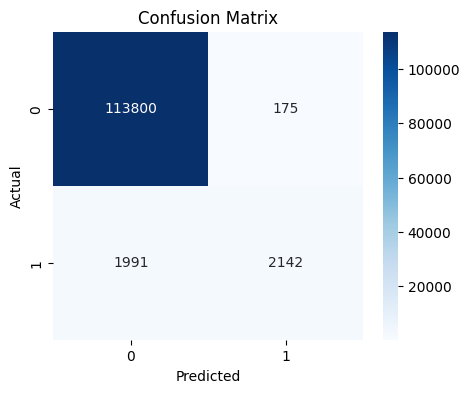

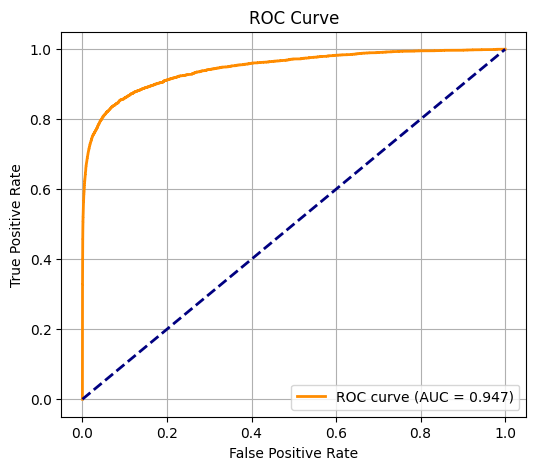

In [10]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

best_params = {
    'model__n_estimators': 900,
    'model__max_depth': 4,
    'model__learning_rate': 0.15157165665103983
}

xgb_pipe.set_params(**best_params)

xgb_pipe.fit(X_train, y_train)
y_pred = xgb_pipe.predict(X_test)
y_proba = xgb_pipe.predict_proba(X_test)[:, 1]  

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


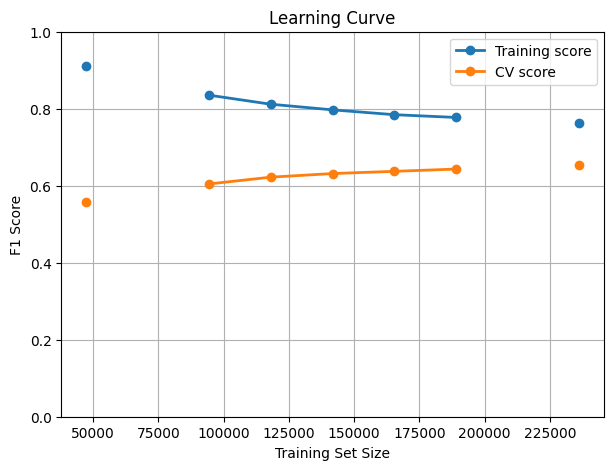

In [16]:
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt

f1_scorer = make_scorer(f1_score, zero_division=0)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    xgb_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=f1_scorer,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=0
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training score', lw=2, markersize=6)
plt.plot(train_sizes, test_mean, 'o-', label='CV score', lw=2, markersize=6)
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.grid(True)
plt.show()


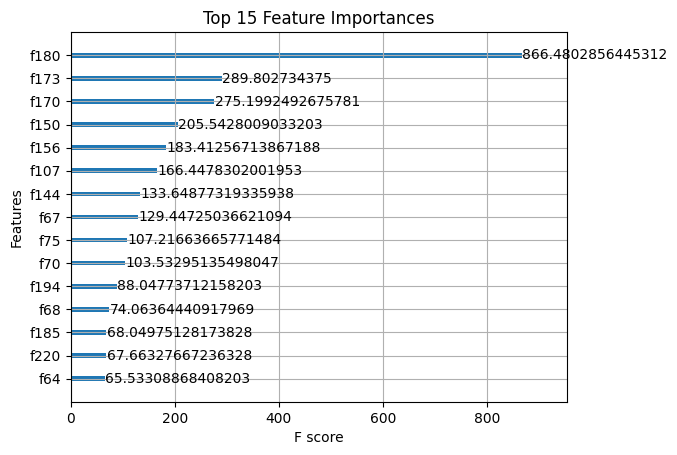

In [12]:
import xgboost as xgb

model = xgb_pipe.named_steps['model']
xgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title('Top 15 Feature Importances')
plt.show()


In [13]:
print("Train mean:", train_mean)
print("Test mean:", test_mean)


Train mean: [       nan 0.87354174        nan        nan        nan 0.76206385]
Test mean: [       nan 0.58474301        nan        nan        nan 0.6546142 ]
